In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime

In [2]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
#path = r'/home/ryuho/Documents/reddy/research/SMRAI/Data/REPPU/200/pbig5min.dat' #Ubuntu
path = r'/home/sachin/Documents/NIPR/Research/Data/REPPU/pbig5min.dat' #Server

#read the REPPU data
with open (path) as f:
    rectype = np.dtype(np.float32)
    reppu_data = np.fromfile(f, rectype) #size = 109,900,800

reppu_data = reppu_data.reshape(-1,30,80)
reppu_data.shape

(45792, 30, 80)

In [5]:
#Read MHD dates and expand-out the date ranges
mhd_data = pd.read_csv('mhd_dates.csv')
expanded_dt = pd.concat([pd.Series(pd.date_range(start, end)) 
    for start, end in zip(mhd_data['start'], mhd_data['end'])])

In [6]:
time_res = 5

if time_res == 1:
    time_step = 1440
else :
    time_step = 288

In [7]:
data_reshaped = reppu_data.reshape(len(expanded_dt), time_step, 30, 80) 

# Define coordinates
time = np.arange(time_step)
lat = np.linspace(53.1, 89.7, 30) #30 intervals between 53.1° to 89.7°
lon = np.linspace(1.6, 357.6, 80) #80 intervals between 1.6° to 357.6°

# Create 'dt' variable combining dates and five-minute intervals
dt = []
for day in expanded_dt:
    for t in time:
        dt.append(day + pd.Timedelta(minutes=t*time_res))
dt = np.array(dt) #convert from list to numpy array

# Create xarray Dataset
ds = xr.Dataset({'potential': (['dt', 'lat', 'lon'], data_reshaped.reshape(-1, 30, 80))},
coords={'dt': dt, 'lat': lat, 'lon': lon})

# Add potential and units
ds['potential'].attrs['units'] = 'kV'
ds['potential'] = ds['potential'] * 1e-3 # Convert to kV
ds

<xarray.Dataset>
Dimensions:    (dt: 45792, lat: 30, lon: 80)
Coordinates:
  * dt         (dt) datetime64[ns] 2021-05-10 ... 2022-08-19T23:55:00
  * lat        (lat) float64 53.1 54.36 55.62 56.89 ... 85.91 87.18 88.44 89.7
  * lon        (lon) float64 1.6 6.106 10.61 15.12 ... 344.1 348.6 353.1 357.6
Data variables:
    potential  (dt, lat, lon) float32 0.6909 0.507 0.3146 ... -22.67 -22.71

In [8]:
omni_df = pd.read_csv('omni_mhd_5min.csv')
#omni_df = pd.read_csv(omni_mhd_path+'omni_mhd_5min.csv')
omni_df.set_index('dt', inplace=True) #set the datetime as the index
omni_df = omni_df.ffill().bfill()
omni_df = omni_df.dropna() #drop any remaining NaNs
omni_df

omni_ds = xr.Dataset(omni_df)
omni_ds['dt'] = pd.to_datetime(omni_ds['dt']) #convert the index to datetime

#merge OMNI with REPPU data
reppu_omni_ds = ds.merge(omni_ds, join='outer')

#select date range
reppu_omni_ds = reppu_omni_ds.sortby('dt')
reppu_omni_ds

if time_res == 1:
    #interpolate the missing values in BY_GSE
    reppu_omni_ds['BY_GSE'] = reppu_omni_ds['BY_GSE'].interpolate_na(dim='dt')
    reppu_omni_ds['BZ_GSE'] = reppu_omni_ds['BZ_GSE'].interpolate_na(dim='dt')
    reppu_omni_ds['flow_speed'] = reppu_omni_ds['flow_speed'].interpolate_na(dim='dt')
    reppu_omni_ds['proton_density'] = reppu_omni_ds['proton_density'].interpolate_na(dim='dt')
    reppu_omni_ds['tilt_angle'] = reppu_omni_ds['tilt_angle'].interpolate_na(dim='dt')

    #drop nan values
    reppu_omni_ds = reppu_omni_ds.dropna('dt')
    reppu_omni_ds
else:
    pass

In [9]:
X_train_a = reppu_omni_ds.sel(dt=slice("2021-05-10","2022-06-30")) #123 days
X_train_b = reppu_omni_ds.sel(dt=slice("2022-08-15","2022-08-19")) #5 days
X_train_ds = xr.concat([X_train_a, X_train_b], dim='dt') #128 days ~ 80% of the data
X_test_ds = reppu_omni_ds.sel(dt=slice("2022-07-01","2022-07-31")) #31 days ~ 20% of the data
X_test_unscaled_ds = X_test_ds.copy() #keep a copy of the unscaled test data for later use

In [10]:
# List of variables to be scaled (excluding 'potential')
variables_to_scale = [var for var in X_train_ds.data_vars if var != 'potential']

# Fit the scaler on training data
scaler = MinMaxScaler()

for var in variables_to_scale:
    # Reshape the variable to (-1, 1) to fit the scaler
    X_train_values = X_train_ds[var].values.reshape(-1, 1)
    X_test_values = X_test_ds[var].values.reshape(-1, 1)

    # Fit and transform on training data, then transform on test data
    scaled_train_values = scaler.fit_transform(X_train_values).reshape(X_train_ds[var].shape)
    scaled_test_values = scaler.transform(X_test_values).reshape(X_test_ds[var].shape)
    
    # Update the xarray dataset with the scaled values
    X_train_ds[var] = (X_train_ds[var].dims, scaled_train_values)
    X_test_ds[var] = (X_test_ds[var].dims, scaled_test_values)


In [11]:
X_train = X_train_ds.drop('potential').to_array().values.T
y_train = X_train_ds['potential'].values
y_train = y_train.reshape(-1, 30*80)

X_test = X_test_ds.drop('potential').to_array().values.T
y_test = X_test_ds['potential'].values
y_test = y_test.reshape(-1, 30*80)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((36864, 5), (36864, 2400), (8928, 5), (8928, 2400))

In [12]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [13]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        # Remove extra dimensions from output
        out = self.fc(out[:, -1, :].squeeze())  # Squeeze the output
        return out

    def reset_states(self):
        # Reset the internal states of the LSTM layer
        self.lstm.reset_parameters()

In [14]:
seq_len = 12 # Number of time steps to look back 
slider = 1 # Number of time steps to slide the window forward

# Instantiate the LSTM model with updated input_size
input_size = X_train.shape[1]
hidden_size = 64
num_layers = 2
output_size = y_train.shape[1]
model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [15]:
mhd_dates = [
    {"start": "2021/05/10 00:00:00", "end": "2021/05/14 23:59:59", "total_days": 5},
    {"start": "2021/05/31 00:00:00", "end": "2021/06/03 23:59:59", "total_days": 4},
    {"start": "2021/07/26 00:00:00", "end": "2021/07/29 23:59:59", "total_days": 4},
    {"start": "2021/09/09 00:00:00", "end": "2021/09/12 23:59:59", "total_days": 4},
    {"start": "2021/10/11 00:00:00", "end": "2021/10/14 23:59:59", "total_days": 4},
    {"start": "2021/11/01 00:00:00", "end": "2021/11/06 23:59:59", "total_days": 6},
    {"start": "2021/11/25 00:00:00", "end": "2021/11/29 23:59:59", "total_days": 5},
    {"start": "2021/12/01 00:00:00", "end": "2022/01/24 23:59:59", "total_days": 55},
    {"start": "2022/01/30 00:00:00", "end": "2022/02/03 23:59:59", "total_days": 5},
    {"start": "2022/03/11 00:00:00", "end": "2022/03/15 23:59:59", "total_days": 5},
    {"start": "2022/03/28 00:00:00", "end": "2022/04/01 23:59:59", "total_days": 5},
    {"start": "2022/06/10 00:00:00", "end": "2022/06/30 23:59:59", "total_days": 20},
    #{"start": "2022/07/01 00:00:00", "end": "2022/07/31 23:59:59", "total_days": 31}, #test data
    {"start": "2022/08/15 00:00:00", "end": "2022/08/19 23:59:59", "total_days": 5}
]

start_indices = []
# Iterate over mhd_dates and find the corresponding indices in xr_ds
for date_range in mhd_dates:
    start_date = datetime.datetime.strptime(date_range["start"], "%Y/%m/%d %H:%M:%S")
    index = (X_train_ds['dt'].values == np.datetime64(start_date)).nonzero()[0][0]
    start_indices.append(index)

# Print the list of start indices
print(start_indices)

[0, 1440, 2592, 3744, 4896, 6048, 7776, 9216, 25056, 26496, 27936, 29376, 35424]


In [16]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((36864, 5), (36864, 2400), (8928, 5), (8928, 2400))

In [17]:
reset_indices = start_indices

# Train the model
rmse_values = []
num_epochs = 50
for epoch in range(num_epochs):
    for i in range(0, len(X_train_tensor) - seq_len + 1, slider):
        inputs = X_train_tensor[i:i + seq_len].to(device)
        targets = y_train_tensor[i + seq_len -1].to(device)
        
        # Reset the model state at start of each date range
        if i in reset_indices:
            model.reset_states()
        
        # Forward pass
        outputs = model(inputs.unsqueeze(0)) # Add batch dimension
        loss = criterion(outputs, targets)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    rmse = np.sqrt(loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.2f}, RMSE: {rmse:.2f} V')
    rmse_values.append(rmse)


Epoch [1/50], Loss: 56.34, RMSE: 7.51 V
Epoch [2/50], Loss: 46.55, RMSE: 6.82 V
Epoch [3/50], Loss: 67.49, RMSE: 8.22 V
Epoch [4/50], Loss: 49.06, RMSE: 7.00 V
Epoch [5/50], Loss: 43.40, RMSE: 6.59 V
Epoch [6/50], Loss: 69.65, RMSE: 8.35 V
Epoch [7/50], Loss: 53.40, RMSE: 7.31 V
Epoch [8/50], Loss: 67.03, RMSE: 8.19 V


KeyboardInterrupt: 

In [ ]:
rmse_values

NameError: name 'rmse_values' is not defined

Text(0, 0.5, 'RMSE (V)')

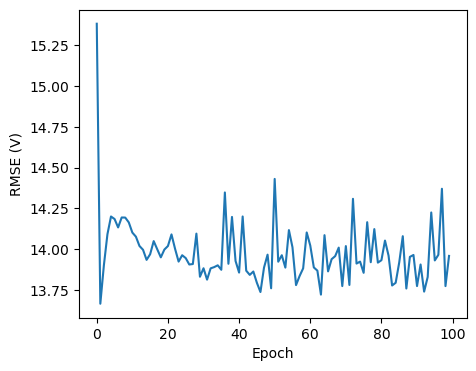

In [ ]:
# Plot the RMSE values
plt.figure(figsize=(5, 4))
plt.plot(rmse_values, label='RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE (V)')